##Connect to Gdrive because I uploaded files in there

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("/content/drive/My Drive/Mobility")


### Loaded packages (some of them are extra, will clean later)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn 
from datetime import datetime
from sklearn import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# !pip3 install bayesian-optimization
from bayes_opt import BayesianOptimization


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier ,ExtraTreesClassifier,AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
# !pip3 install catboost
from catboost import CatBoostClassifier
import operator

### Read train test files and EDA (Need to do more EDA)

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [5]:
train.dtypes

Trip_ID                         object
Trip_Distance                  float64
Type_of_Cab                     object
Customer_Since_Months          float64
Life_Style_Index               float64
Confidence_Life_Style_Index     object
Destination_Type                object
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var1                           float64
Var2                             int64
Var3                             int64
Gender                          object
Surge_Pricing_Type               int64
dtype: object

In [6]:
test.dtypes

Trip_ID                         object
Trip_Distance                  float64
Type_of_Cab                     object
Customer_Since_Months          float64
Life_Style_Index               float64
Confidence_Life_Style_Index     object
Destination_Type                object
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var1                           float64
Var2                             int64
Var3                             int64
Gender                          object
dtype: object

In [7]:
print(train.isna().sum())

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64


In [8]:
print(test.isna().sum())

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    13158
Customer_Since_Months           3966
Life_Style_Index               13327
Confidence_Life_Style_Index    13327
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           46789
Var2                               0
Var3                               0
Gender                             0
dtype: int64


In [9]:
train.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,60632.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,64.202698,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,21.820447,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,30.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,46.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,61.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,80.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,210.000000,124.000000,206.000000,3.000000


In [10]:
train.select_dtypes(include=['object'])

,Trip_ID,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
0,T0005689460,B,A,A,Female
1,T0005689461,B,B,A,Male
2,T0005689464,NaN,NaN,E,Male
3,T0005689465,C,NaN,A,Male
4,T0005689467,C,B,A,Male
...,...,...,...,...,...
131657,T0005908509,D,A,A,Male
131658,T0005908510,C,C,A,Male
131659,T0005908512,C,B,A,Female
131660,T0005908513,B,A,B,Male


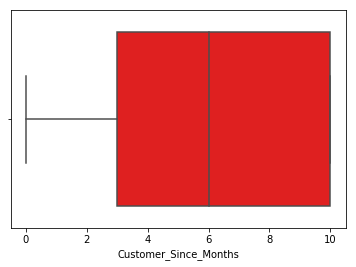

In [11]:
sns.boxplot(x='Customer_Since_Months',data=train,color='red')

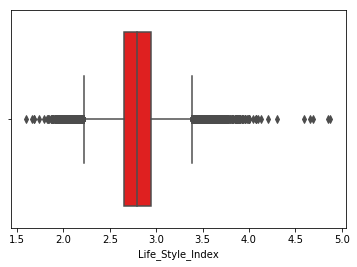

In [12]:
sns.boxplot(x='Life_Style_Index',data=train,color='red')

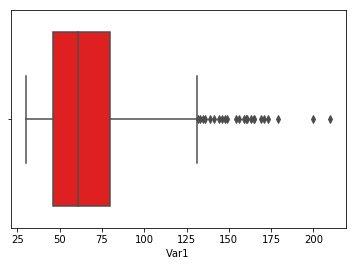

In [13]:
sns.boxplot(x='Var1',data=train,color='red')

In [14]:
print(train.isna().sum())

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64


In [15]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [5]:
df_num_corr = train.corr()['Surge_Pricing_Type'][:-1]
features_list = df_num_corr[df_num_corr > 0.1].sort_values(ascending=False)
features_list

Cancellation_Last_1Month    0.185646
Trip_Distance               0.135928
Name: Surge_Pricing_Type, dtype: float64

In [6]:
train_num = train.select_dtypes(include = ['float64', 'int64'])
individual_features_df = []
for i in range(0, len(train_num.columns) - 1):
    tmpDf = train_num[[train_num.columns[i], 'Surge_Pricing_Type']]
    tmpDf = tmpDf[tmpDf[train_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['Surge_Pricing_Type'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>20}: {:>5}".format(key, value))

     Customer_Rating: -0.155279271593299
    Life_Style_Index: -0.08010768728632614
                Var1: -0.040734761187583284
                Var3: -0.039308573266452575
                Var2: 0.0034367010185634675
Customer_Since_Months: 0.02458993448151122
Cancellation_Last_1Month: 0.10437538582106334
       Trip_Distance: 0.13592839560015293


In [18]:
train['Surge_Pricing_Type'].describe()

count    131662.000000
mean          2.155747
std           0.738164
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: Surge_Pricing_Type, dtype: float64

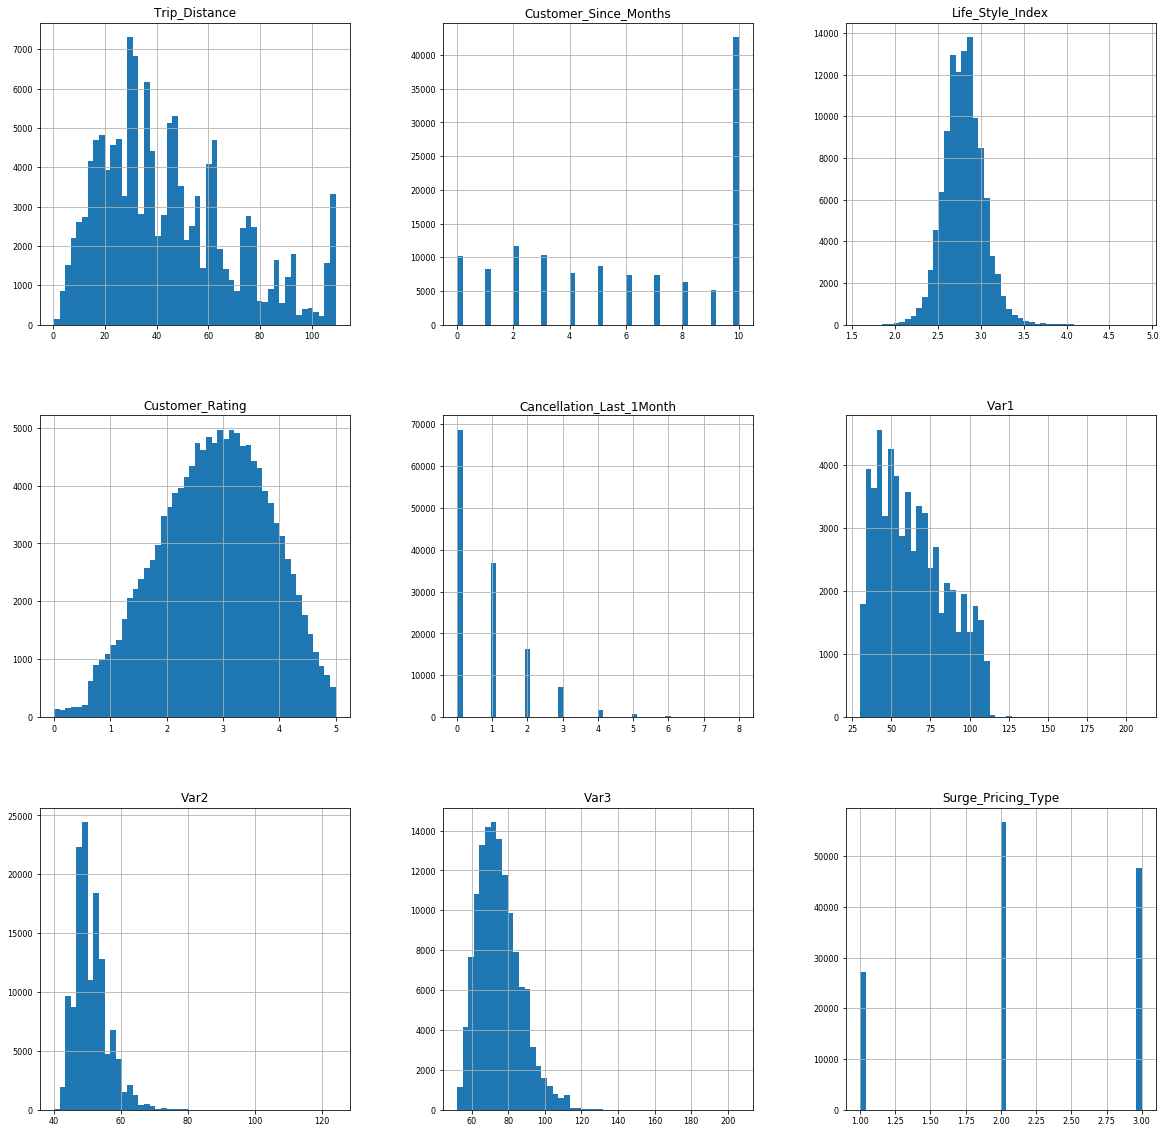

In [19]:
train.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

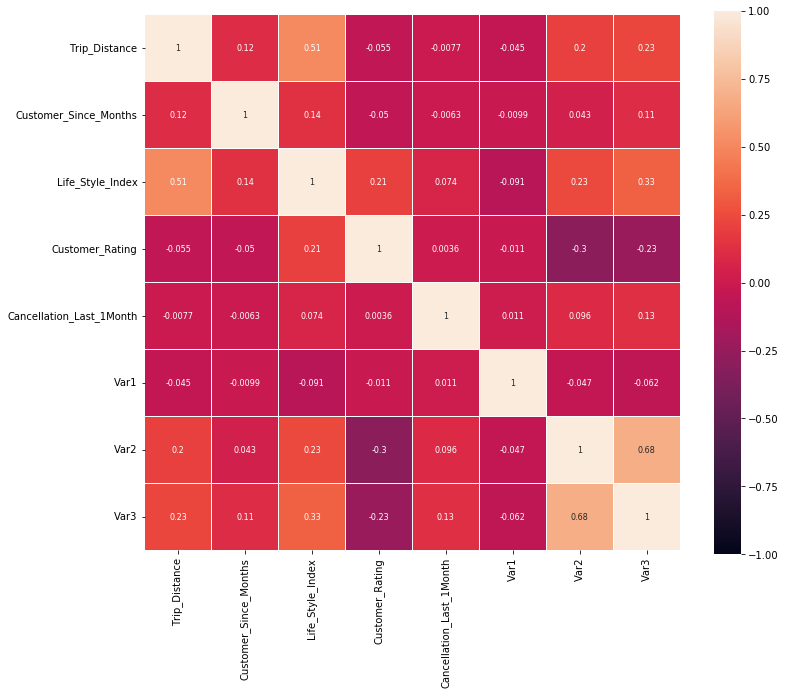

In [20]:
corr = train.drop('Surge_Pricing_Type', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr, 
             vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [7]:
train_categ_columns = list(train.select_dtypes(include=['object']))
train_categ_columns.append('Surge_Pricing_Type')
train_categ = train[train_categ_columns]
train_categ.head()

,Trip_ID,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender,Surge_Pricing_Type
0,T0005689460,B,A,A,Female,2
1,T0005689461,B,B,A,Male,2
2,T0005689464,NaN,NaN,E,Male,2
3,T0005689465,C,NaN,A,Male,3
4,T0005689467,C,B,A,Male,2


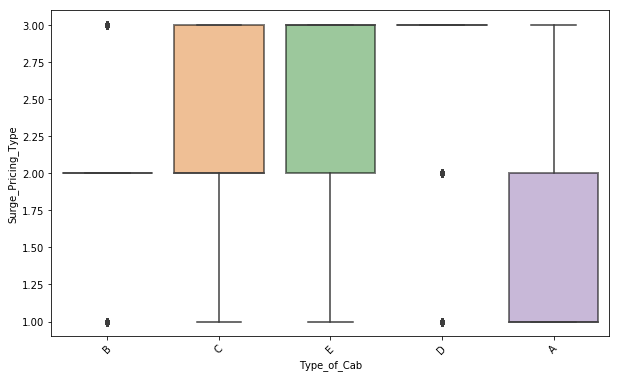

In [22]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Type_of_Cab', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

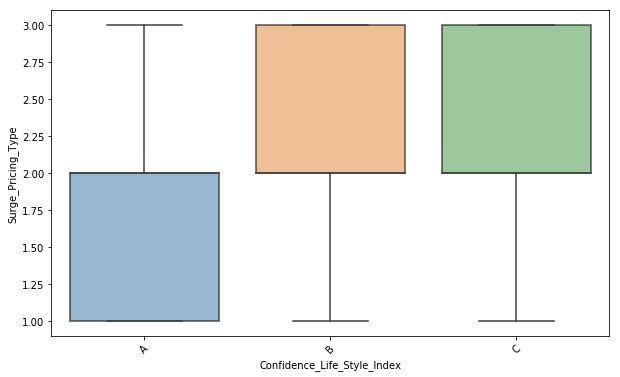

In [23]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Confidence_Life_Style_Index', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

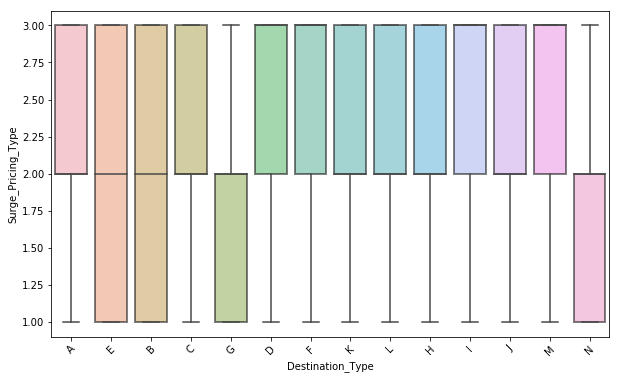

In [24]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Destination_Type', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

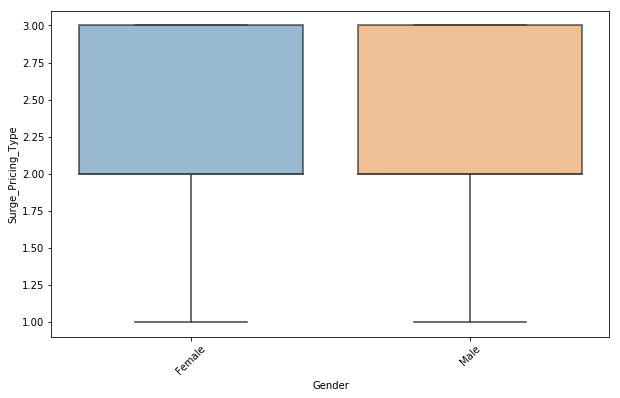

In [25]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Gender', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

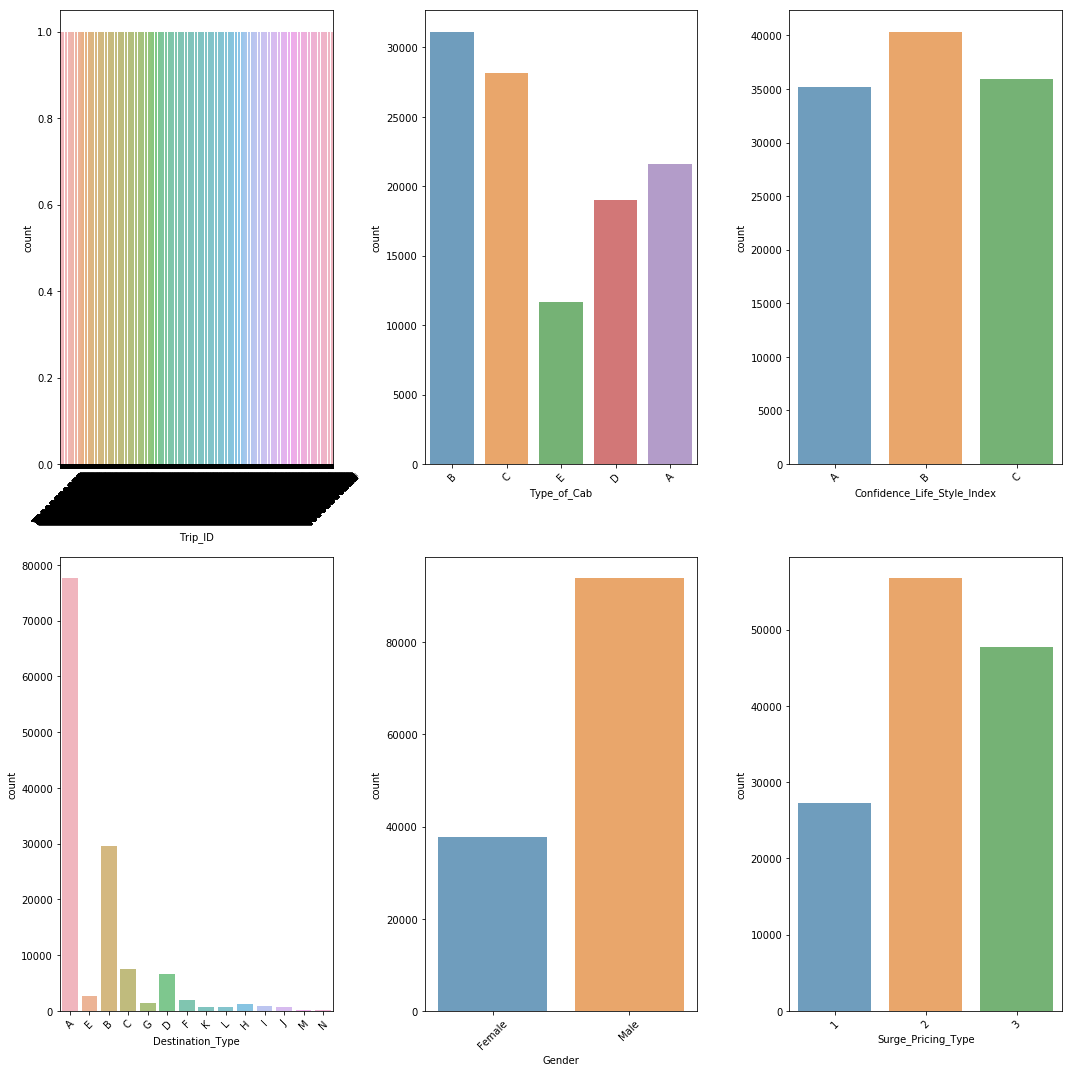

In [35]:
fig, axes = plt.subplots(round(len(train_categ.columns) / 3), 3, figsize=(15, 15))

for i, ax in enumerate(fig.axes):
    if i < len(train_categ.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=train_categ.columns[i], alpha=0.7, data=train_categ, ax=ax)

fig.tight_layout()

## Treatment of NA Values (Can try more things)

In [8]:
#treating NA values
train['Type_of_Cab'].fillna("B", inplace=True)
test['Type_of_Cab'].fillna("B", inplace=True)

train['Confidence_Life_Style_Index'].fillna("B", inplace=True)
test['Confidence_Life_Style_Index'].fillna("B", inplace=True)

for col in ['Customer_Since_Months','Var1']:
    train[col].fillna(train[col].median(), inplace = True)
for col in ['Customer_Since_Months','Var1']:
    test[col].fillna(test[col].median(), inplace = True)

train['Var1']=train['Var1'].astype('int')
test['Var1']=test['Var1'].astype('int')

train['Life_Style_Index'].fillna(train['Life_Style_Index'].mean(), inplace = True)
test['Life_Style_Index'].fillna(test['Life_Style_Index'].mean(), inplace = True)


train['Customer_Since_Months']=train['Customer_Since_Months'].astype('int')
test['Customer_Since_Months']=test['Customer_Since_Months'].astype('int')


In [9]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1,2.427690,A,A,3.90500,0,40,46,60,Female,2
1,T0005689461,29.47,B,10,2.782450,B,A,3.45000,0,38,56,78,Male,2
2,T0005689464,41.58,B,10,2.802064,B,E,3.50125,2,61,56,77,Male,2
3,T0005689465,61.56,C,10,2.802064,B,A,3.45375,0,61,52,74,Male,3
4,T0005689467,54.95,C,10,3.034530,B,A,3.40250,4,51,49,102,Male,2


In [28]:
test.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,A,10,2.57438,A,B,3.68000,2,61,46,63,Male
1,T0005689462,32.15,B,10,2.85143,A,A,1.59375,0,65,49,80,Female
2,T0005689463,10.38,C,4,2.70530,A,D,4.50500,0,61,47,74,Male
3,T0005689466,14.94,B,6,2.48159,C,E,4.53000,0,63,43,54,Male
4,T0005689468,32.03,B,7,2.81598,A,K,4.60125,3,96,44,56,Male


### Label Encoding (We can decide if necessary or not)

In [10]:
train.Type_of_Cab.value_counts()

B    51346
C    28122
A    21569
D    18991
E    11634
Name: Type_of_Cab, dtype: int64

In [11]:
le = LabelEncoder()
trained_le = le.fit(train["Type_of_Cab"])
train["Type_of_Cab"] = trained_le.transform(train["Type_of_Cab"])
test["Type_of_Cab"] = trained_le.transform(test["Type_of_Cab"])
train.head(10)

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1,1,2.427690,A,A,3.90500,0,40,46,60,Female,2
1,T0005689461,29.47,1,10,2.782450,B,A,3.45000,0,38,56,78,Male,2
2,T0005689464,41.58,1,10,2.802064,B,E,3.50125,2,61,56,77,Male,2
3,T0005689465,61.56,2,10,2.802064,B,A,3.45375,0,61,52,74,Male,3
4,T0005689467,54.95,2,10,3.034530,B,A,3.40250,4,51,49,102,Male,2
5,T0005689469,19.06,4,10,2.802064,B,A,2.59750,1,72,63,91,Male,3
6,T0005689470,29.72,4,10,2.839580,C,B,2.97500,1,83,50,75,Male,2
7,T0005689472,18.44,1,2,2.818710,B,A,3.58250,0,103,46,63,Male,2
8,T0005689473,106.80,2,3,2.802064,B,A,3.14625,0,61,58,92,Male,2
9,T0005689474,107.19,3,5,3.044670,B,A,2.44375,1,61,58,83,Male,3


In [12]:
train.Confidence_Life_Style_Index.value_counts()

B    60548
C    35967
A    35147
Name: Confidence_Life_Style_Index, dtype: int64

In [13]:
le = LabelEncoder()
trained_le = le.fit(train["Confidence_Life_Style_Index"])
train["Confidence_Life_Style_Index"] = trained_le.transform(train["Confidence_Life_Style_Index"])
test["Confidence_Life_Style_Index"] = trained_le.transform(test["Confidence_Life_Style_Index"])
train.head(10)

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1,1,2.427690,0,A,3.90500,0,40,46,60,Female,2
1,T0005689461,29.47,1,10,2.782450,1,A,3.45000,0,38,56,78,Male,2
2,T0005689464,41.58,1,10,2.802064,1,E,3.50125,2,61,56,77,Male,2
3,T0005689465,61.56,2,10,2.802064,1,A,3.45375,0,61,52,74,Male,3
4,T0005689467,54.95,2,10,3.034530,1,A,3.40250,4,51,49,102,Male,2
5,T0005689469,19.06,4,10,2.802064,1,A,2.59750,1,72,63,91,Male,3
6,T0005689470,29.72,4,10,2.839580,2,B,2.97500,1,83,50,75,Male,2
7,T0005689472,18.44,1,2,2.818710,1,A,3.58250,0,103,46,63,Male,2
8,T0005689473,106.80,2,3,2.802064,1,A,3.14625,0,61,58,92,Male,2
9,T0005689474,107.19,3,5,3.044670,1,A,2.44375,1,61,58,83,Male,3


In [46]:
train.Destination_Type.value_counts()

A    77597
B    29555
C     7484
D     6588
E     2717
F     1950
G     1489
H     1260
I      813
J      695
K      680
L      643
N       98
M       93
Name: Destination_Type, dtype: int64

In [16]:
le = LabelEncoder()
trained_le = le.fit(train["Destination_Type"])
train["Destination_Type"] = trained_le.transform(train["Destination_Type"])
test["Destination_Type"] = trained_le.transform(test["Destination_Type"])
train.head(10)

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1,1,2.427690,0,0,3.90500,0,40,46,60,0,2
1,T0005689461,29.47,1,10,2.782450,1,0,3.45000,0,38,56,78,1,2
2,T0005689464,41.58,1,10,2.802064,1,4,3.50125,2,61,56,77,1,2
3,T0005689465,61.56,2,10,2.802064,1,0,3.45375,0,61,52,74,1,3
4,T0005689467,54.95,2,10,3.034530,1,0,3.40250,4,51,49,102,1,2
5,T0005689469,19.06,4,10,2.802064,1,0,2.59750,1,72,63,91,1,3
6,T0005689470,29.72,4,10,2.839580,2,1,2.97500,1,83,50,75,1,2
7,T0005689472,18.44,1,2,2.818710,1,0,3.58250,0,103,46,63,1,2
8,T0005689473,106.80,2,3,2.802064,1,0,3.14625,0,61,58,92,1,2
9,T0005689474,107.19,3,5,3.044670,1,0,2.44375,1,61,58,83,1,3


In [17]:
le = LabelEncoder()
trained_le = le.fit(train["Gender"])
train["Gender"] = trained_le.transform(train["Gender"])
test["Gender"] = trained_le.transform(test["Gender"])
train.head(10)

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1,1,2.427690,0,0,3.90500,0,40,46,60,0,2
1,T0005689461,29.47,1,10,2.782450,1,0,3.45000,0,38,56,78,1,2
2,T0005689464,41.58,1,10,2.802064,1,4,3.50125,2,61,56,77,1,2
3,T0005689465,61.56,2,10,2.802064,1,0,3.45375,0,61,52,74,1,3
4,T0005689467,54.95,2,10,3.034530,1,0,3.40250,4,51,49,102,1,2
5,T0005689469,19.06,4,10,2.802064,1,0,2.59750,1,72,63,91,1,3
6,T0005689470,29.72,4,10,2.839580,2,1,2.97500,1,83,50,75,1,2
7,T0005689472,18.44,1,2,2.818710,1,0,3.58250,0,103,46,63,1,2
8,T0005689473,106.80,2,3,2.802064,1,0,3.14625,0,61,58,92,1,2
9,T0005689474,107.19,3,5,3.044670,1,0,2.44375,1,61,58,83,1,3


In [49]:
train.dtypes

Trip_ID                         object
Trip_Distance                  float64
Type_of_Cab                      int64
Customer_Since_Months            int64
Life_Style_Index               float64
Confidence_Life_Style_Index      int64
Destination_Type                 int64
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var1                             int64
Var2                             int64
Var3                             int64
Gender                           int64
Surge_Pricing_Type               int64
dtype: object

In [50]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,1,1,2.427690,0,0,3.90500,0,40,46,60,0,2
1,T0005689461,29.47,1,10,2.782450,1,0,3.45000,0,38,56,78,1,2
2,T0005689464,41.58,5,10,2.802064,3,4,3.50125,2,61,56,77,1,2
3,T0005689465,61.56,2,10,2.802064,3,0,3.45375,0,61,52,74,1,3
4,T0005689467,54.95,2,10,3.034530,1,0,3.40250,4,51,49,102,1,2


In [19]:
df_num_corr = train.corr()['Surge_Pricing_Type'][:-1]
features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=False)
features_list

Type_of_Cab                    0.503093
Cancellation_Last_1Month       0.185646
Trip_Distance                  0.135928
Confidence_Life_Style_Index    0.115344
Customer_Rating               -0.155279
Name: Surge_Pricing_Type, dtype: float64